# Black Box Analysis 

Understanding the outcomes of Machine Learning models is becoming an important aspect of the field as practitoners demand knowledge of why models work. It is not sufficient to simply have models "that work" in most fields. This notebook and others in the folder will look at how tree learning models such as XGBoost and GradientBoostingClassifier(GBC) can have the critical features explained via Partial Dependance Plots(PDPs). 

Since XGBoost is not compatible with the Scikit-learn PDP functions, an equivalent model is fit using GBC where the feature dependance is then drawn from and compared to the XGBoost feature importance equivalent. 

In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics   
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
trainData = pd.read_csv('1e7data_train.csv', index_col=0)
testData = pd.read_csv('1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData

In [2]:
feature_names = []
feature_names += ['daOverRH1', 'daOverRH2']
feature_names += ['mindaOverRH', 'maxdaOverRH']
feature_names += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
feature_names += ['norm_std_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'norm_max_a2']
feature_names += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
feature_names += ['avg_ecross1', 'std_ecross1', 'min_ecross1', 'max_ecross1']
feature_names += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
feature_names += ['avg_ecross3', 'max_ecross3', 'min_ecross3', 'std_ecross3']
feature_names += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
feature_names += ['norm_LyapunovTime']


X_train = df[feature_names]

y_train = df['Stable']
X_test = dftest[feature_names]

X_train = X_train.replace(np.nan, -999)
X_train = X_train.replace(np.inf, -999)

X_test = X_test.replace(np.nan, -999)
X_test = X_test.replace(np.inf, -999)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='deviance', learning_rate=0.002, n_estimators=5000,
                                  subsample=.5,  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=8,
                                  init=None, random_state=42, 
                                  max_leaf_nodes=8, warm_start=False, max_features=.5)

model.fit(X_train, y_train)

dtest_predictions = model.predict(X_test) 
dtest_predprob = model.predict_proba(X_test)[:, 1]

#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dftest['Stable'].values, dtest_predictions)
print "AUC Score (Test): %f" % metrics.average_precision_score(dftest['Stable'], dtest_predprob)
print 'ROC_AUC_Score: ', metrics.roc_auc_score(dftest['Stable'], dtest_predprob)




Model Report
Accuracy : 0.8873
AUC Score (Test): 0.895186
ROC_AUC_Score:  0.945591898717


Now we can begin the Partial Dependance Analysis, we'll use the XGBoost feature impoartance to try and zone in on which features we should begin with. 


Model Report
Accuracy : 0.8893
AUC Score (Test): 0.901201
ROC_AUC_Score:  0.950015356265


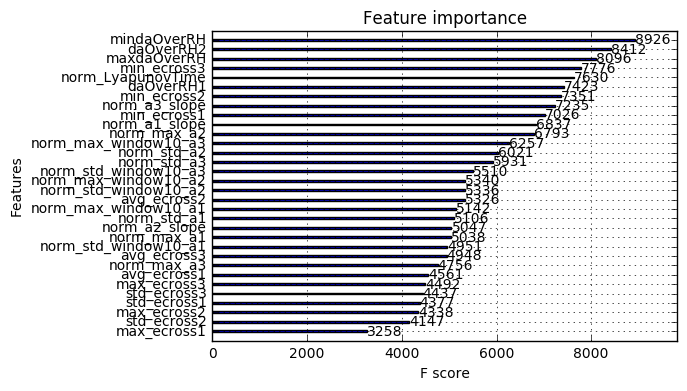

In [4]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 

model0 = XGBClassifier(colsample_bylevel=1, colsample_bytree=1,
                         n_estimators=5000, gamma=0,
                         max_delta_step=0, missing=None, 
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1, seed=27,
                        learning_rate=.002, max_depth=8,
                        subsample=.5, min_child_weight=1.2, 
                        objective='binary:logistic', nthread=-1)

model0.fit(X_train, y_train)

dtest_predictions = model0.predict(X_test) 
dtest_predprob = model0.predict_proba(X_test)[:, 1]



#Print model report:
print "\nModel Report"
print "Accuracy : %.4g" % metrics.accuracy_score(dftest['Stable'].values, dtest_predictions)
print "AUC Score (Test): %f" % metrics.average_precision_score(dftest['Stable'], dtest_predprob)
print 'ROC_AUC_Score: ', metrics.roc_auc_score(dftest['Stable'], dtest_predprob)

xgb.plot_importance(model0)


In [5]:
# putting the features in order of XGBoosts feature importance rank

import operator 
imp_vals = model0.booster().get_fscore()
sorted_vals = sorted(imp_vals.items(), key = operator.itemgetter(1), reverse=True)
feature_names = []
for scores in sorted_vals: 
    feature_names.append(scores[0])

PDPs represent the effect of one or many variables on the outcome of a model; each point on the plot is the average vote percentage in favor of class 1 trees across all observations given the fixed value of the independant variable whos partial dependance is being plotted; the downfall of using these methods is that to visualize them they must be in 2D or 3D which may leave out important higher order interactions. 

How the Partial Dependence is calculated according to the documentation: 

"At each non-terminal node that splits on a target variable either the left child or the right child is visited based on the feature value of the current sample and the wegiht is not modified. At each non temrinal node that splits on a complementary feautre both children are visited and the weight is multiplied by the fraction of training samples which went to each child. 

At each terminal node the value of the node is multiplied by the current weight (wegihts sum to 1 for all visited terminal nodes)."

From my reading, the y-axis is the importance the feature plays in predicitng the target class, values greater than 1 are intepreted as the range of values more likely to predict the target classe, 0 is no effect on prediction, and negative values means that the positive class is less likely in the range of values; it is interesting to note that most of the features below are heavily skewed toward the negative range. 

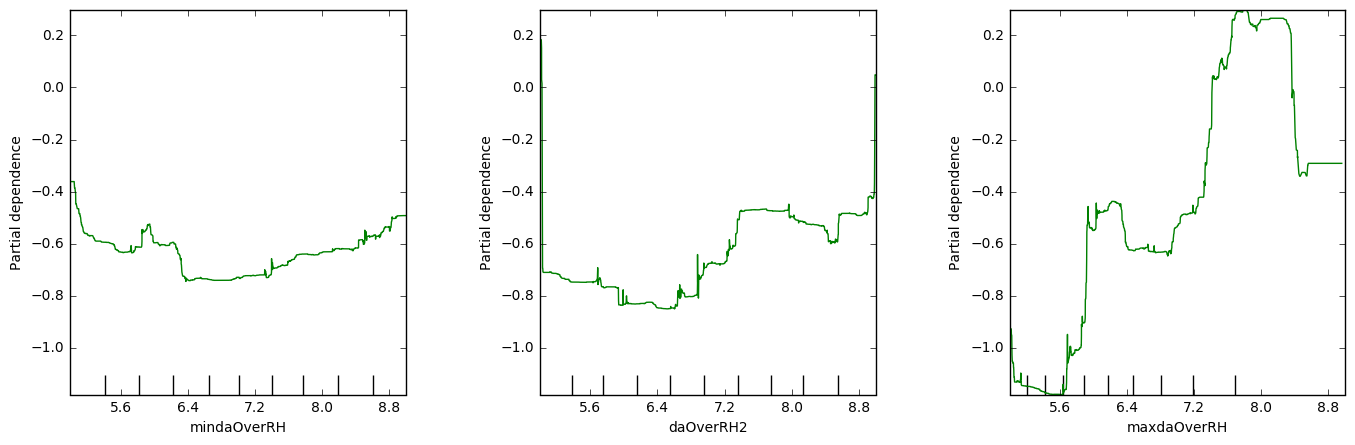

In [63]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

features = [0,1,2] 
names = feature_names

fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=10000, figsize=(15,7))

plt.show()

From our first set of plots, we see that its likely that XGBoost determines feature importance by impact on the target class, as the plots progress, they tend to get closer to -1 partial dependance, with plots closer to the top of XGBoost's feature importance having a higher range of values in the positive range; however we'll see a contradiction to this belief below.  

From above its interesting to see that daOverRH2 has tails that predict the positive class, but has the entire middle range below 0. 

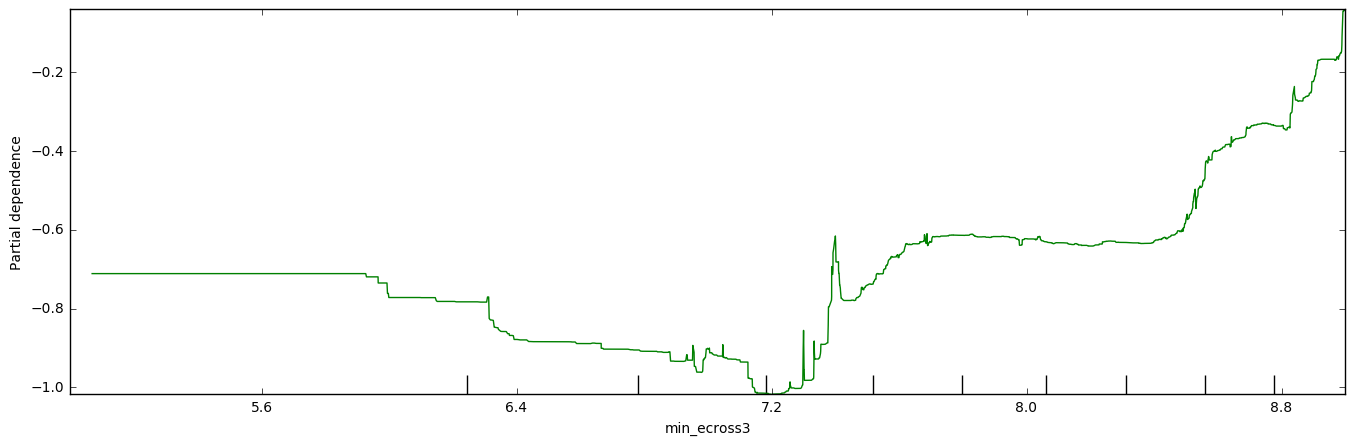

In [66]:
features = [3] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=10000, figsize=(15,7)
                                  )

plt.show()

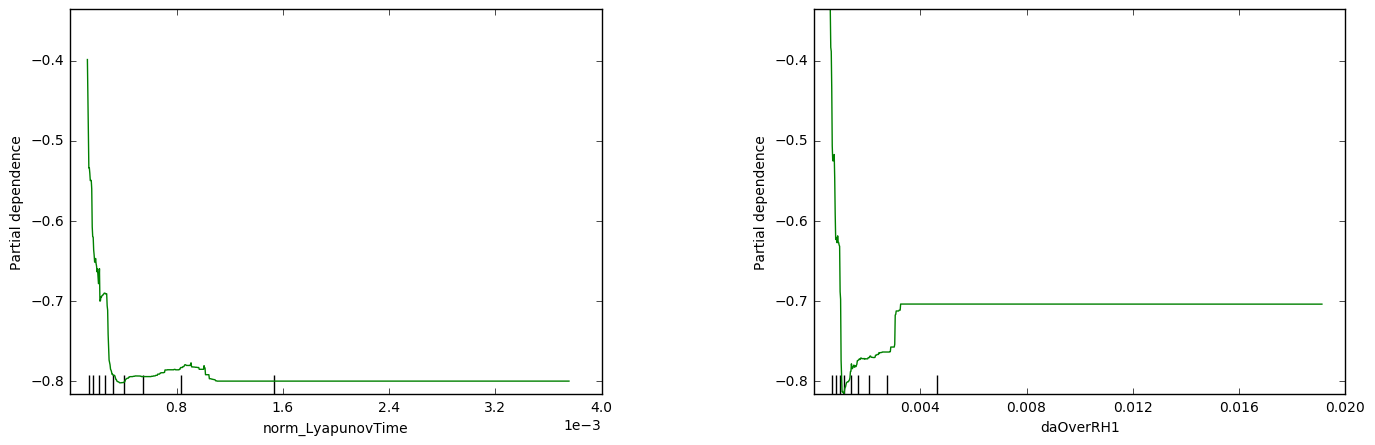

In [68]:
features = [4, 5] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15,7)
                                  )

plt.show()

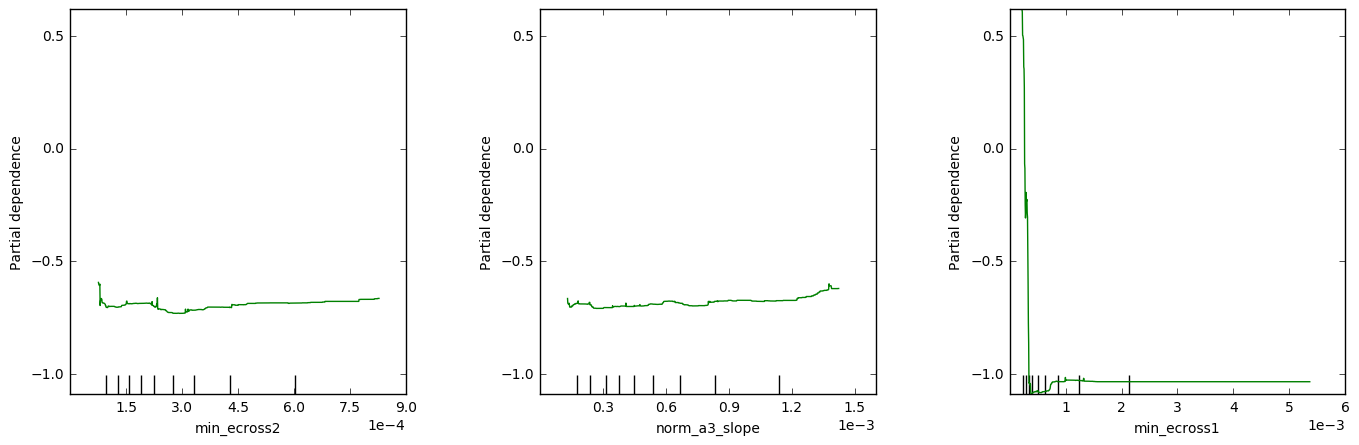

In [46]:
features = [6, 7, 8] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15, 7))

plt.show()

We see a contradiction here to the guess that XGBoost orders its features in terms of importance for predicting the target class, as min_ecross1 seems to hit a peak of >.5 when predicting the positive class yet the features plotted above are deemed more important to XGBoost. Given the wide range of values close to or below negative 1, this could be an effect of averaging out importance, leading it to look like the two plots on the left. 

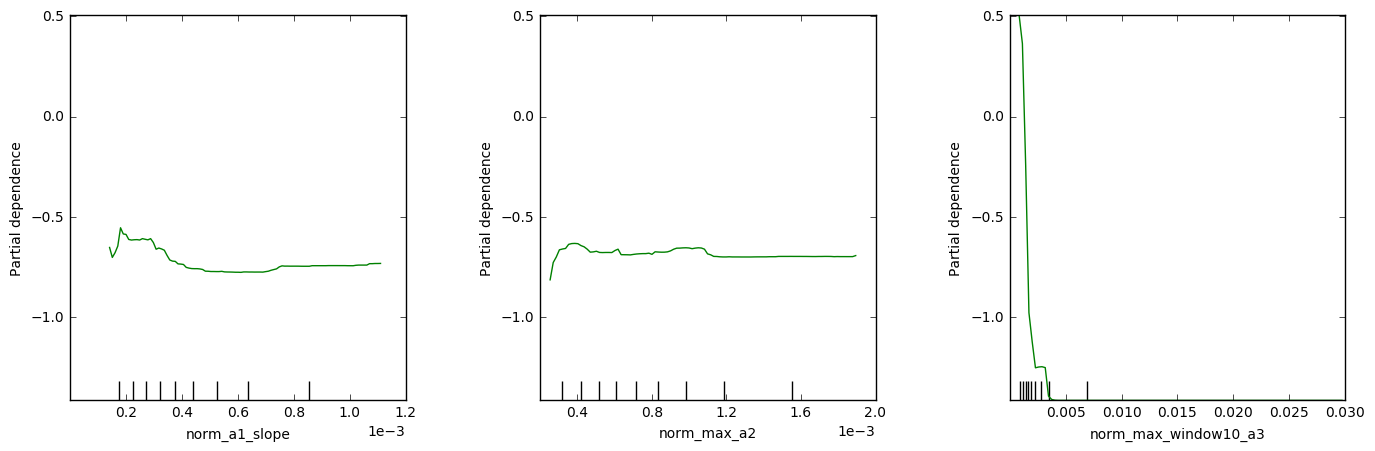

In [49]:
features = [9, 10, 11] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=100, figsize=(15,7))

plt.show()

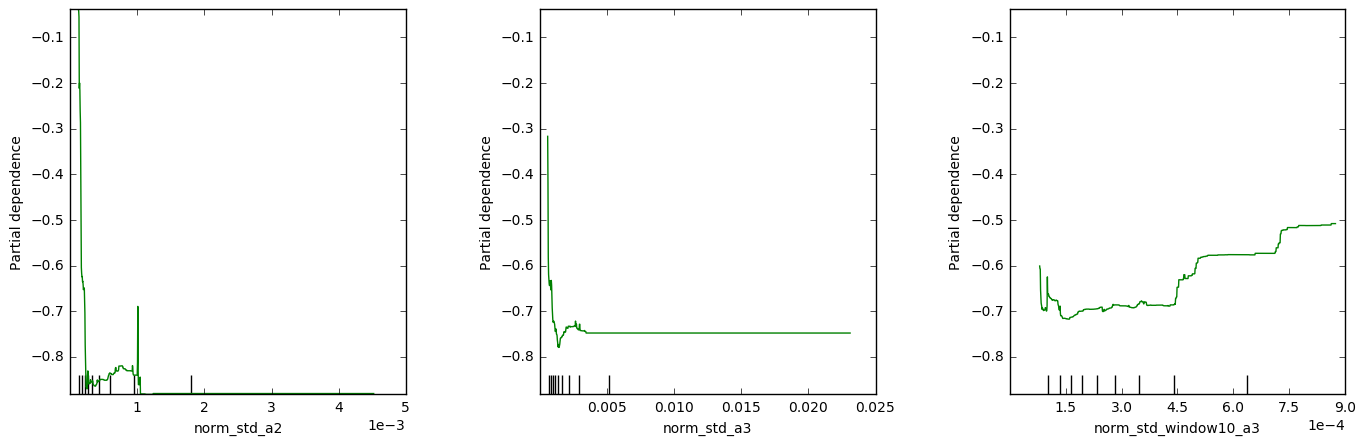

In [52]:
features = [12, 13, 14] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15,7))

plt.show()

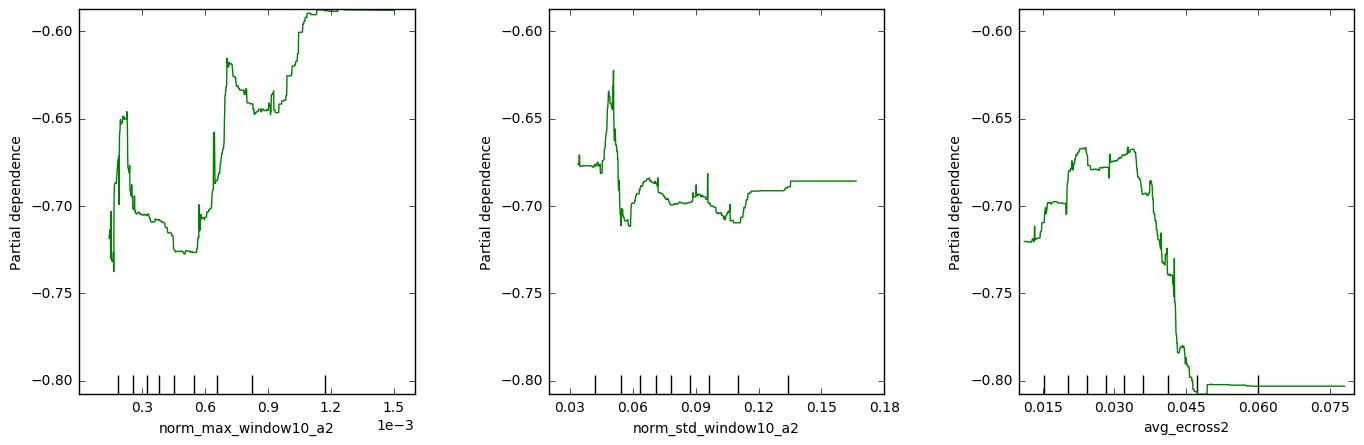

In [54]:
features = [15, 16, 17] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15,7))

plt.show()

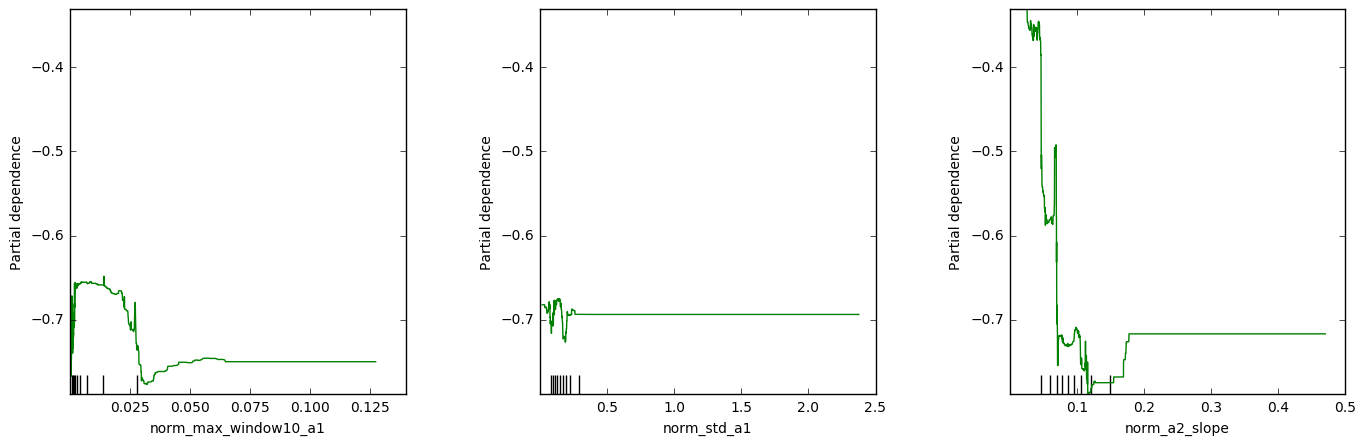

In [55]:
features = [18, 19, 20] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=10000, figsize=(15, 7))

plt.show()

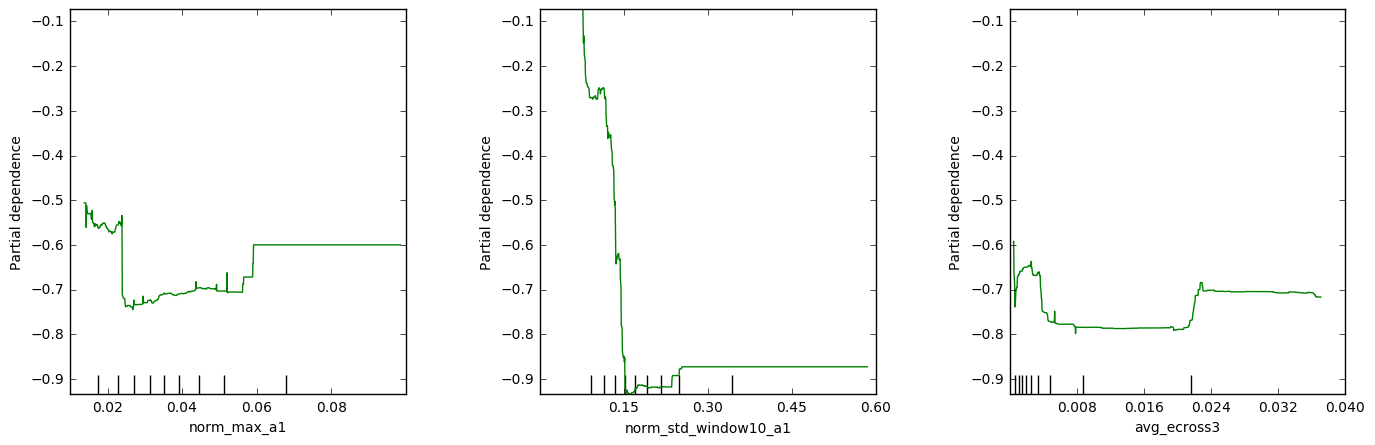

In [71]:
features = [21, 22, 23] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15, 7))

plt.show()

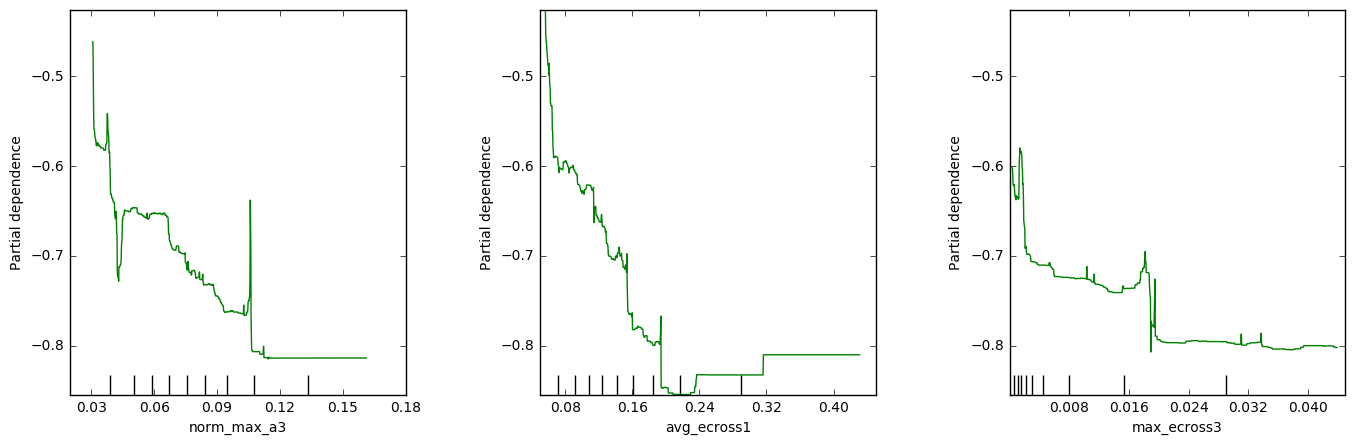

In [60]:
features = [24, 25, 26] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15, 7))

plt.show()

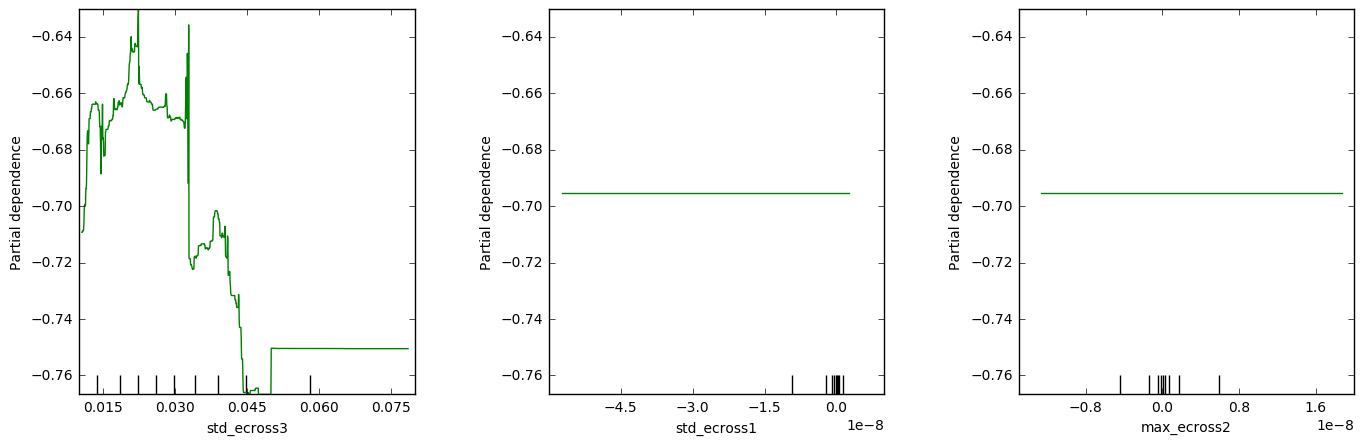

In [39]:
features = [27, 28, 29] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=1000, figsize=(15, 7))

plt.show()

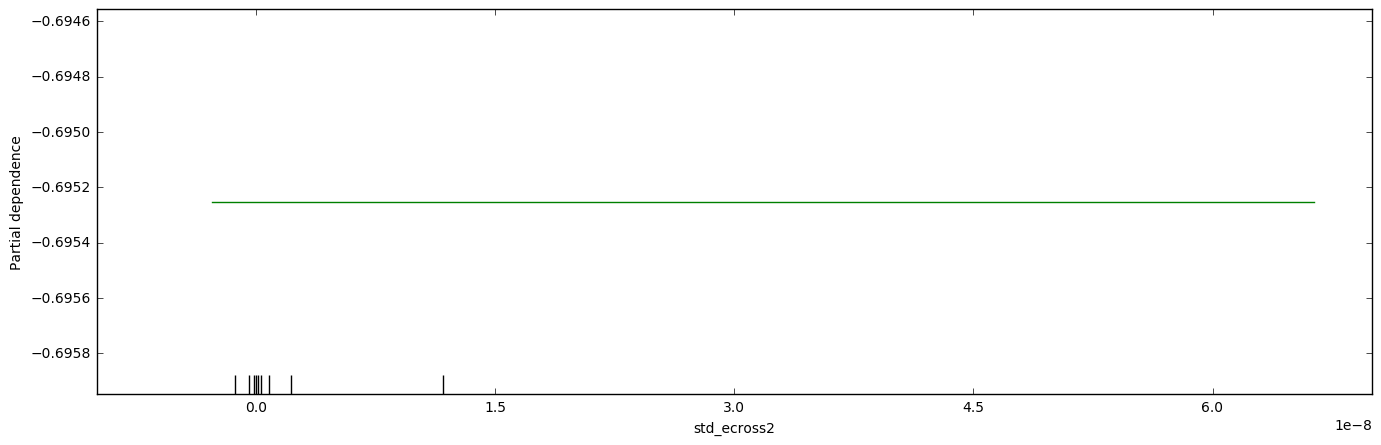

In [41]:
features = [30] 
names = feature_names

# grid resolution is the # of equally spaced points on the axes
fig, axs = plot_partial_dependence(model, X_train, features,
                                       feature_names=names,
                                       n_jobs=6, grid_resolution=100, figsize=(15, 7))

plt.show()

Towards the bottom we see that features begin to flatline, and are predictors for the negative class. 

More interesting trends we can see is that some of these features seem to play a very strong role in a very small range of values such as avgecross3, norm_a2_slope, norm_std_a3, norm_std_a2, minecross2, maxDAoverRH. Furthermore there seems to be a trend when comparing XGBoost Feature Importance and GBC, and that is that features tend to occupy more values in the negative partial dependence range the closer they get to the bottom of the Feature Importance score ranking. 

Perhaps a strategy in the future may be to drop features that are at the bottom of importance, or to limit the range of values for features to those that greatly predict the positive class and replacing the range of values outside of this with a dummy variable. 